# Introduction

Plankton are microorganisms that form the base of the aquatic food chain. Photosynthetic plankton also play a crucial role in the global carbon cycle, as well as producing much of the world's oxygen. Because of their importance to the marine ecosystem, monitoring the health of the plankton population is a key component of oceanic research. One method to monitor plankton populations over time is through in-situ imaging of individual planktonic organisms. In-situ monitoring allows for the collection of not just abundance data but also morphological information on various species of plankton. 

The Martha's Vineyard Coastal Observatory operates an imaging flow cytometer (the MVCO FlowCytobot) that operates continuously and takes photographs of individual plankton cells in the water column. The large amount of image data generated by this machine necessitates the development of automated methods to classify plankton images. The Woods Hole Oceanographic Institute which operates the FlowCytobot has released several datasets of expert labeled plankton images for the purpose of training machine learning models to classify plankton by species. The main dataset, WHOI-plankton contains >3.5 million labeled images of plankton from 103 classes. Unfortunately, the dataset is highly imbalanced, with 6 classes comprising up to 85% of the whole dataset. Imbalanced datasets can hamper the performance of machine learning models due to underfitting of training on rarer classes. One solution for imbalanced datasets is to augment the images of the rarer classes to balance the dataset.

# Method 

In this notebook, I explored the use of a generative adversarial network (GAN) to generate synthetic images of plankton from the WHOI-plankton dataset. The synthetic images can be used to augment the training data for the rarer classes in the dataset. The GAN model was trained on a balanced subset of the WHOI-plankton dataset containing 22 classes and 6598 images. This dataset is called WHOI22. In addition, I used traditional image augmentation techniques to gradually replace the images of the WHOI22 dataset to evaluate the impace of image augmentation on transfer learning performance.

# Results

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, models, optimizers, losses, metrics
from keras import ops
import tensorflow as tf
import datetime
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import EfficientNetB7

2024-05-09 22:01:42.142447: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 22:01:45.606693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 22:01:56.887402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Image examples

Here are some examples of the images in the WHOI22 dataset:

In [2]:
image_size = (256, 256)
batch_size = 32
def load_data(batch_size=batch_size):
    train_data = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)
    test_data = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)
    return train_data, test_data
train_data, test_data = load_data()

Found 3300 files belonging to 22 classes.


2024-05-09 22:02:19.938745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1055 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:ca:00.0, compute capability: 8.0


Found 3298 files belonging to 22 classes.


2024-05-09 22:02:26.453834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 0.98, 'Example images from WHOI22')

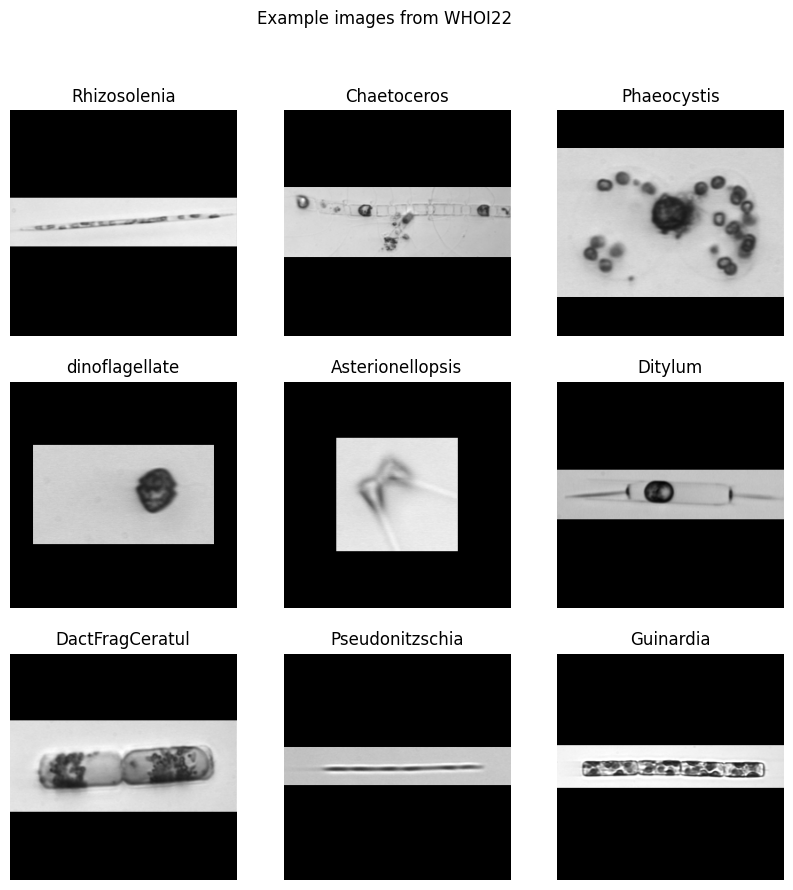

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_data.class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Example images from WHOI22")

## Image Augmentation

I created a function to augment a proportion of the images in the WHOI22 dataset and replace the original images with the augmented images. I evaluated the impact of image augmentation on the performance of the EfficientNetB7 model. Below is the code I used to create new augmented datasets, based on the keras tutorial (https://www.tensorflow.org/tutorials/images/data_augmentation). 

In [4]:
## Code to augment dataset 

## Code to create new augmented dataset
def augment_dataset(dataset, augmentation_pipeline, augmentation_ratio=1.0):
    def augment(image, label):
        augmented_image = augmentation_pipeline(image)
        return augmented_image, label

    # Apply the augmentation to a subset of the dataset
    augmented_dataset = dataset.take(int(len(dataset) * augmentation_ratio))
    augmented_dataset = augmented_dataset.map(lambda image, label: augment(image, label))

    # Concatenate the augmented and unaugmented data if not fully augmented
    if augmentation_ratio < 1.0:
        remaining_dataset = dataset.skip(int(len(dataset) * augmentation_ratio))
        augmented_dataset = augmented_dataset.concatenate(remaining_dataset)

    return augmented_dataset

## Code for my augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom((-.5, 0),(-.5,0)),
    layers.RandomContrast(.5)
    ])

augmented_dataset = augment_dataset(train_data, data_augmentation, 1.0)

2024-05-09 22:02:28.099993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


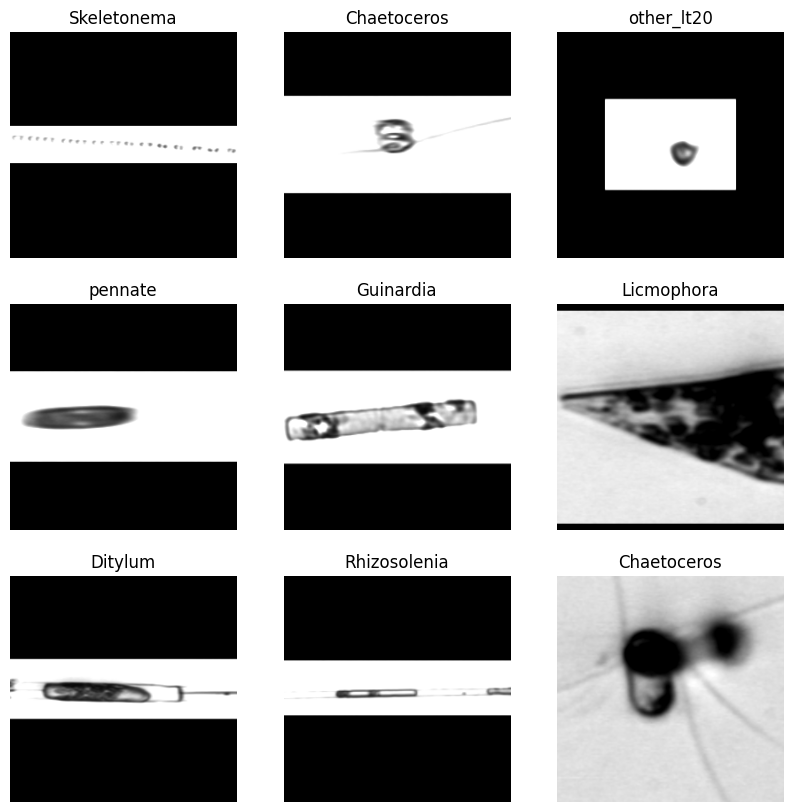

In [5]:
# Display examples of augmented data
plt.figure(figsize=(10, 10))
for images, labels in augmented_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_data.class_names[tf.argmax(labels[i])])
        plt.axis("off")

I then trained evaluated the efficacy of transfer learning over an increasing proportion of augmented images. Due to time constrants, I trained over a range of (0, 0.25, 0.75, and 1.0) for the proportion of augmented images for 30 epochs each. 

In [ ]:
%%script false --no-raise-error
def run_experiment(augmentation_ratios, train_dataset, test_dataset, image_size):
    results = []

    for ratio in augmentation_ratios:
        # Create the augmented dataset
        augmented_train_dataset = augment_dataset(train_dataset, data_augmentation, ratio)

        # Define the model
        base_model = EfficientNetB7(
            weights='imagenet',
            input_shape=(image_size, image_size, 3),
            include_top=False
        )
        base_model.trainable = False
        inputs = layers.Input(shape=(image_size, image_size, 3))

        x = base_model(inputs, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(22)(x)
        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(),
            loss=losses.CategoricalCrossentropy(from_logits=True),
            metrics=[metrics.CategoricalAccuracy()]
        )

        # Train the model
        history = model.fit(augmented_train_dataset, epochs=20, validation_data=test_dataset)

        # Evaluate the model
        predictions = model.predict(test_dataset)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.concatenate([y for x, y in test_dataset], axis=0)
        true_classes = np.argmax(true_classes, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(true_classes, predicted_classes)
        precision = precision_score(true_classes, predicted_classes, average='macro')
        recall = recall_score(true_classes, predicted_classes, average='macro')
        f1 = f1_score(true_classes, predicted_classes, average='macro')

        results.append({
            'augmentation_ratio': ratio,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'history': history
        })

    return results
agumentation_ratios = [0, 0.25, 0.5, 1.0]
experiment_results = run_experiment(augmentation_ratios, train_data, test_data, image_size)

The resulting experimental results were:

|Ratio|accuracy|precision|recall|f1_score|
|---|---|---|---|---|
|0|0.9302607640994542|0.9320761423156214|0.9302538902538903|0.9303629824439483|
|0.25|0.9311704063068527|0.9330203341078452|0.9311425061425062|0.9309755673991812|
|0.75|0.9269254093389934|0.92934612963181|0.9268959868959871|0.9272655730029147|
|1.0|0.9041843541540328|0.9110883620776806|0.9041482391482389|0.9052793430903048|

There was a small loss across all metrics but overall remained surprisingly high

Increasing the ratio of augmented images did not seem to affect the nature of the learning curves
<div>
<img src="images/r0.png" width="400"/>
</div>

<div>
<img src="images/r1.png" width="400"/>
</div>

<div>
<img src="images/r2.png" width="400"/>
</div>

<div>
<img src="images/r3.png" width="400"/>
</div>

# GAN Model

I intended to train a GAN to generate new images of plankton images to compare with the image augmentation dataset. However, I was not able to create a GAN that converged and generated reasonable images. In this section, I will document the code I used and the experiments I performed in an attempt to train the GAN. I used the Conditional GAN model from the keras tutorials (https://keras.io/examples/generative/conditional_gan/) and adapted a generator/discriminator architecture from a paper by Vallez et al 2022 (https://doi.org/10.1016/j.cmpb.2022.106775). The Vallez et al paper created a conditional GAN on a Diatom dataset (a type of plankton, not part of the WHOI dataset) to benchmark their own novel image augmentation method for images of highly variable shape and texture. From the paper:

> In this work, we have used a generator composed of 5 blocks. Each one contains a batch normalization, a rectified linear unit activation and a transposed convolution with 512, 256, 128, 64 and 3 filters (the last one produces the image, and therefore the 3 filters correspond to the color channels). At the top of the generator, the latent vector (the features used as input for the network) is initialized randomly, with a size equal to the input ( features). On the other side, the discriminator reproduces the same architecture, but inverted. For this purpose, each block contains regular convolution layers and the output is a single neuron to predict whether the input is real or fake.

Below is my interpretation of the Generator/Discriminator architecture and the ConditionalGAN model. Throughout testing, I varied the number of layers in both the generator and discriminator as I resized the images

In [ ]:
def get_generator_block(filters):
    return keras.Sequential([
        layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        ]
    )

def make_generator(generator_channels):
    return keras.Sequential([
        keras.Input(shape=(generator_channels,)),
        layers.Normalization(),
        layers.Dense(4*4*generator_channels),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, generator_channels)),
        #get_generator_block(256),
        get_generator_block(128),
        get_generator_block(64),
        get_generator_block(32),
        get_generator_block(16),
        get_generator_block(8),
        layers.Conv2D(3, (7,7), padding="same", activation="tanh")
    ])

def get_discriminator_block(size):
    return keras.Sequential([
        layers.Conv2D(size, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
    ])

def make_discriminator(image_size, discriminator_channels):
    return keras.Sequential([
        keras.Input(shape=(image_size, image_size, discriminator_channels)),
        layers.Normalization(),
        get_discriminator_block(3),
        get_discriminator_block(8),
        get_discriminator_block(64),
        get_discriminator_block(128),
        #get_discriminator_block(256),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation="sigmoid")
    ])

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
def run_experiment(discriminator, generator, latent_dim, epochs, learning_rate_d, learning_rate_g, data):
    dt_format = "%Y-%m-%d-%H-%M-%S"
    dt = datetime.datetime.now().strftime(dt_format)
    callbacks_dir = f"callbacks/{dt}"
    callbacks = [
        keras.callbacks.BackupAndRestore(callbacks_dir, save_freq="epoch", delete_checkpoint=True), 
        keras.callbacks.CSVLogger('callbacks/'+dt+'.log')
    ]
    gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_d),
        g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_g),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    history = gan.fit(data, epochs=epochs, callbacks=callbacks)
    return gan, history

# Example of learning rates used
initial_learning_rate = .01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)
discriminator_lr = 1e-6

I tested multiple hyperparameters, but the model always diverged. Below is a list of experiments I tried:

|Generator LR| Discriminator LR|Epochs|Image size|Dataset size|
|---|---|---|---|---|
|0.0003|0.003|30|256|train only (3k)|
|decay with initial 0.01|1e-5|30|256|3k|
|decay with initial 0.01|1e-5|30|256|combined training and test set (6k)|
|decay with initial 0.01|1e-5|120|256|3k|
|decay with initial 0.01|1e-5|120|256|6k|
|decay with initial 0.01|1e-5|1000|256|3k|
|decay with initial 0.01|1e-5|1000|64|3k|

Below are representative images for some of the experiments. 

Default learning rate

<div>
<img src="images/loss_no_lr.png" width="250"/>
</div>

Learning rate schedule applied
<div>
<img src="images/loss.png" width="250"/>
</div>

Combined training and test set
<div>
<img src="images/loss_6k.png" width="250"/>
</div>

Increased to 120 epochs, 3k sample size
<div>
<img src="images/loss_3k_120epochs.png" width="250"/>
</div>

120 epochs with 6k sample size
<div>
<img src="images/loss_6k_120epochs.png" width="250"/>
</div>

1000 epochs with 3k sample size
<div>
<img src="images/loss_3k_1000epochs.png" width="250"/>
</div>

Downsizing to 64 pixels for 1000 epochs
<div>
<img src="images/loss_64px_1000epochs.png" width="250"/>
</div>


I also attempted to make the base MNIST conditional gan work for my images. However, I was met with the same result.
<div>
<img src="images/mnist_plankton.png" width="250"/>
</div>

Future efforts to train a GAN might include beginning with a pretrained model such as styleGAN or attempting different architectures. 

# Conclusions and caveats

Overall, I found that increased data augmentation lead to a decrease in the initial quality and speed of transfer learning from a pre-trained model. However, even with 100% of the data being augmented, classification accuracy was not completely obliterated, contrary to expectations. One caveat to this method of augmentation is that I took each image and applied a distortion to it, therefore the diversity of input images remained the same. In future experiments it would be better to replace the dataset with distorted images originating from the first 20 images of the set. However, I discovered this oversight too late and did not correct. Thus, this reduction in model training effectiveness represents perhaps a best-case scenario for image data augmentation. 

# Appendix of methods

## Data preprocessing

Images were downloaded from Olsen & Sosik 2007 (https://doi.org/10.4319/lom.2007.5.195) in tif format. I padded the images to a square aspect ratio with black pixels to 256x256 and saved as bmp. 

In [ ]:
%%script false --no-raise-error
# Function that takes a tiff image and pads it to the desired size (square) and returns a numpy array
def pad_image(image, size):
    # load the image
    img = tif.imread(image)
    # get image dimensions
    x,y = img.shape
    # calculate the padding
    x_pad = size - x
    y_pad = size - y
    # check if padding is needed, if not, resize the image maintaining aspect ratio
    if x_pad < 0 or y_pad < 0:
        if x > y:
            new_x = size
            new_y = int(y * (size/x))
        else:
            new_y = size
            new_x = int(x * (size/y))
        img = np.array(Image.fromarray(img).resize((new_y, new_x)))
        x,y = img.shape
        x_pad = size - x
        y_pad = size - y
    # pad the image
    if x_pad > 0 or y_pad > 0:
        x_pad1, x_pad2 = x_pad//2, x_pad-x_pad//2
        y_pad1, y_pad2 = y_pad//2, y_pad-y_pad//2
        img = np.pad(img, ((x_pad1, x_pad2), (y_pad1, y_pad2)), 'constant')
    return img

# Function that takes a folder and pads each image in the folder. Inputs are the input path, output path.
def pad_folder(input_path, output_path, size):
    # make the output path
    os.makedirs(output_path, exist_ok=True)
    subfolders = [f.path for f in os.scandir(input_path) if f.is_dir()]
    for folder in subfolders:
        # use base folder name as class
        class_name = os.path.basename(folder)
        # make the output class folder
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)
        # get all the images in the folder
        images = [f.path for f in os.scandir(folder) if f.is_file()]
        for img in images:
            # input image path
            img_in_path = img
            # output image path
            img_out_path = os.path.join(output_path, class_name, os.path.basename(img))
            img_out_path = img_out_path.replace('.tif', '.bmp')
            # print statment
            print(f"Padding {img_in_path} to {img_out_path}")
            # pad the image and save it
            try:
                img_output = pad_image(image=img_in_path, size=size)
                # write img as bmp
                im = Image.fromarray(img_output)
                im.save(img_out_path)
            except Exception as e:
                print("failed to pad image", img_in_path, e)
pad_folder(input_path='datasets/testing', output_path="datasets/padded_testing", size=256)
pad_folder(input_path='datasets/training', output_path="datasets/padded_training", size=256)